In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from collections import defaultdict
from utils_analysis import prepare_scores
from typing import Literal


def get_results_name(steps: int, split: Literal["train", "test"]):
    return f"/home/mila/f/floresl/beam-search/results/xsum_analysis_by_50/{split}/bart-base_data_xsum_checkpoint-{steps}_xsum_10_rows.json"


def get_scores(scores_json_filepath: str):
    metric = "rougeL"
    test_filepath = "/home/mila/f/floresl/beam-search/data/xsum/test.csv"
    temperature = 0.001
    targets = [str(s) for s in pd.read_csv(test_filepath)["target"].fillna("")]  # type: ignore
    results = prepare_scores(scores_json_filepath, targets, metric, temperature)
    correlation_dict: dict[str, float] = (
        results.scores_dataframe.drop(["sentences", "dropout_sentences"], axis=1)
        .corr(method="spearman")[metric]
        .to_dict()  # type: ignore
    )
    return correlation_dict

Using the latest cached version of the module from /home/mila/f/floresl/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--bertscore/cf4907b18f8f741f202232c0f8009a3bd49ff98802c245abcb6ea51a37a8c05b (last modified on Sat Sep 28 09:35:22 2024) since it couldn't be found locally at evaluate-metric--bertscore, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from /home/mila/f/floresl/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--sari/a0dd86b272c088d488925f5735d937ac3f21014d322792ed359597d8a8faaf9b (last modified on Sat Sep 28 09:35:23 2024) since it couldn't be found locally at evaluate-metric--sari, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from /home/mila/f/floresl/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--meteor/e7ed321a1b44c34fa4679192809db2cee7e3bd4bba0fe8b76061d807706c2374 (last modified on Sat Sep 28 09:35:23 2024) since it couldn't be found 

In [2]:
results = defaultdict(list[float])
for i in range(1, 11):
    epoch_result = get_scores(get_results_name(50 * i, "test"))
    metric_k = None
    for key in epoch_result:
        metric_name = key
        metric_value = epoch_result[key]
        if metric_name.startswith("beam_score"):
            metric_k = metric_name.split("_")[-1]
            metric_name = "_".join(metric_name.split("_")[:-1])
        results[metric_name].append(metric_value)
    if metric_k:
        results["k"].append(int(metric_k))

/home/mila/f/floresl/beam-search/analysis/utils_tail_probs.py:48: RuntimeWarning: invalid value encountered in divide
  return nums_w_exp / nums_w_exp.sum()
/home/mila/f/floresl/beam-search/analysis/utils_analysis.py:49: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  abs(spearmanr(ground_truth_score, confidence_score_dict[str(k)]).statistic)  # type: ignore
/home/mila/f/floresl/beam-search/analysis/utils_analysis.py:49: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  abs(spearmanr(ground_truth_score, confidence_score_dict[str(k)]).statistic)  # type: ignore


/home/mila/f/floresl/beam-search/analysis/utils_tail_probs.py:48: RuntimeWarning: invalid value encountered in divide
  return nums_w_exp / nums_w_exp.sum()
/home/mila/f/floresl/beam-search/analysis/utils_analysis.py:49: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  abs(spearmanr(ground_truth_score, confidence_score_dict[str(k)]).statistic)  # type: ignore
/home/mila/f/floresl/beam-search/analysis/utils_tail_probs.py:48: RuntimeWarning: invalid value encountered in divide
  return nums_w_exp / nums_w_exp.sum()
/home/mila/f/floresl/beam-search/analysis/utils_analysis.py:49: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  abs(spearmanr(ground_truth_score, confidence_score_dict[str(k)]).statistic)  # type: ignore
/home/mila/f/floresl/beam-search/analysis/utils_tail_probs.py:48: RuntimeWarning: invalid value encountered in divide
  return nums_w_exp / nums_w_exp.sum()
/home/mila/f/floresl/beam

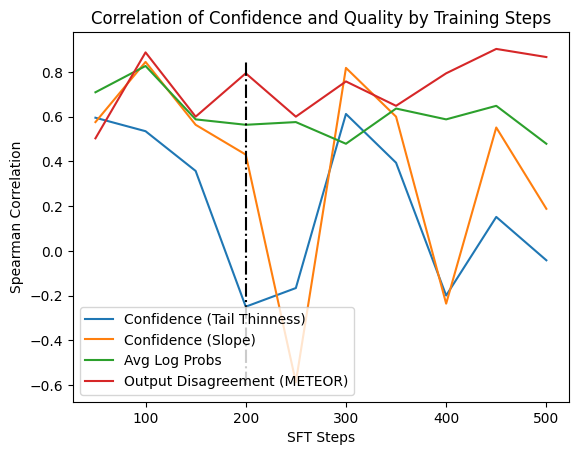

In [8]:
x = [i * 50 for i in list(range(1, 11))]
plt.plot(x, results["tail_index"], label="Confidence (Tail Thinness)")
plt.plot(x, results["beam_score_ratios"], label="Confidence (Slope)")
plt.plot(x, results["length_normalized_log_probs"], label="Avg Log Probs")
plt.plot(x, results["dropout_meteor_score"], label="Output Disagreement (METEOR)")
plt.xlabel("SFT Steps")
plt.ylabel("Spearman Correlation")
plt.vlines(x=200, ymin=-0.6, ymax=0.85, color="black", linestyles="dashdot")
plt.legend()
plt.title("Correlation of Confidence and Quality by Training Steps")
plt.show()